In [1]:
import numpy as np
import os
import pandas as pd
import h5py
from scipy.io import loadmat
import socket
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
warnings.simplefilter("ignore", category=RuntimeWarning)

hostname = socket.gethostname()
p = {}
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datd'] = '/d/DATD/datd/MD_TMS_EEG'
else:
    p['datd'] = '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datd/MD_TMS_EEG'
p['data'] = p['datd'] + '/data'
p['analysis'] = p['datd'] + '/analysis'
p['EEGfiles'] = p['datd'] + '/EEGfiles'
p['meta'] = p['analysis'] + '/meta_analysis'
p['df_fname'] = os.path.join(p['meta'], 'calib_filtered.csv')
p['ALI_evoked'] = os.path.join(p['EEGfiles'], 'ALI_evoked_basecorr1.mat')
p['ALI_induced'] = os.path.join(p['EEGfiles'], 'ALI_induced_basecorr1.mat')
p['mCDA'] = os.path.join(p['EEGfiles'], 'CDA.mat')
p['training_data'] = os.path.join(p['EEGfiles'], 'training_data.npy')
# Load up summary meta-data
summary_df = pd.read_csv(os.path.join(p['analysis'] + '/EEG_TMS_meta_Summary.csv'))
All_metadata = {row['Subject ID']: row for _, row in summary_df.iterrows()}

# Load up behavioral data
df_behav = pd.read_csv(p['df_fname'])
df_behav['trl_idx'] = df_behav['rnum'] * df_behav['tnum']

In [2]:
# Load up ALI evoked and induced
with h5py.File(p['ALI_evoked'], 'r') as f:
    X_evoked = np.array(f['mALI']).T
    y_evoked = np.array(f['trl_mat']).T
yevoked_df = pd.DataFrame(y_evoked, columns = ['subjID', 'day', 'istms', 't_type', 'trl_idx'], dtype='int')

with h5py.File(p['ALI_induced'], 'r') as f:
    X_induced = np.array(f['mALI']).T
    y_induced = np.array(f['trl_mat']).T
yinduced_df = pd.DataFrame(y_induced, columns = ['subjID', 'day', 'istms', 't_type', 'trl_idx'], dtype='int')

# Load up the time array
with h5py.File(os.path.join(p['EEGfiles'], 'sub01/day01/sub01_day01_TFR_evoked.mat')) as f:
    time_array = np.array(f['POW']['pin']['time'])

# Create data with just trials that were retained after both behavioral and EEG trial-rejection
master_df = pd.merge(df_behav.reset_index(), yevoked_df.drop(columns=['istms']).reset_index(), on=['subjID', 'day', 'trl_idx'], how='inner', indicator=True)
idx_behav = master_df['index_x'].tolist()
idx_ALI = master_df['index_y'].tolist()
master_df = master_df.drop(columns=['index_x', 'Unnamed: 0', 'index_y', '_merge'])
Xcommon_evoked = X_evoked[idx_ALI, :]
Xcommon_induced = X_induced[idx_ALI, :]

# Make a list of different trial-types
trial_types = ['pin', 'pout', 'ain', 'aout']
tms_cond = [0, 1]

OSError: Unable to open file (truncated file: eof = 22310103, sblock->base_addr = 512, stored_eof = 3698824385)

In [ ]:
# Compute ALI average per subject
sub_list = yevoked_df['subjID'].unique()
ALI_evoked = np.zeros((len(tms_cond), len(trial_types), len(sub_list), len(time_array)))
ALI_induced = np.zeros((len(tms_cond), len(trial_types), len(sub_list), len(time_array)))
for ii, cond in enumerate(tms_cond):
    for jj, t_type in enumerate(trial_types):
        idx = yevoked_df.loc[(yevoked_df['istms'] == cond) & (yevoked_df['t_type'] == jj+1)].index
        this_df = yevoked_df.iloc[idx].reset_index(drop=True)
        this_X_evoked = X_evoked[idx, :]
        this_X_induced = X_induced[idx, :]
        for kk in range(len(sub_list)):
            this_idx = this_df.index[this_df['subjID'] == sub_list[kk]].tolist()
            ALI_evoked[ii, jj, kk, :] = np.nanmean(this_X_evoked[this_idx, :], 0)
            ALI_induced[ii, jj, kk, :] = np.nanmean(this_X_induced[this_idx, :], 0)

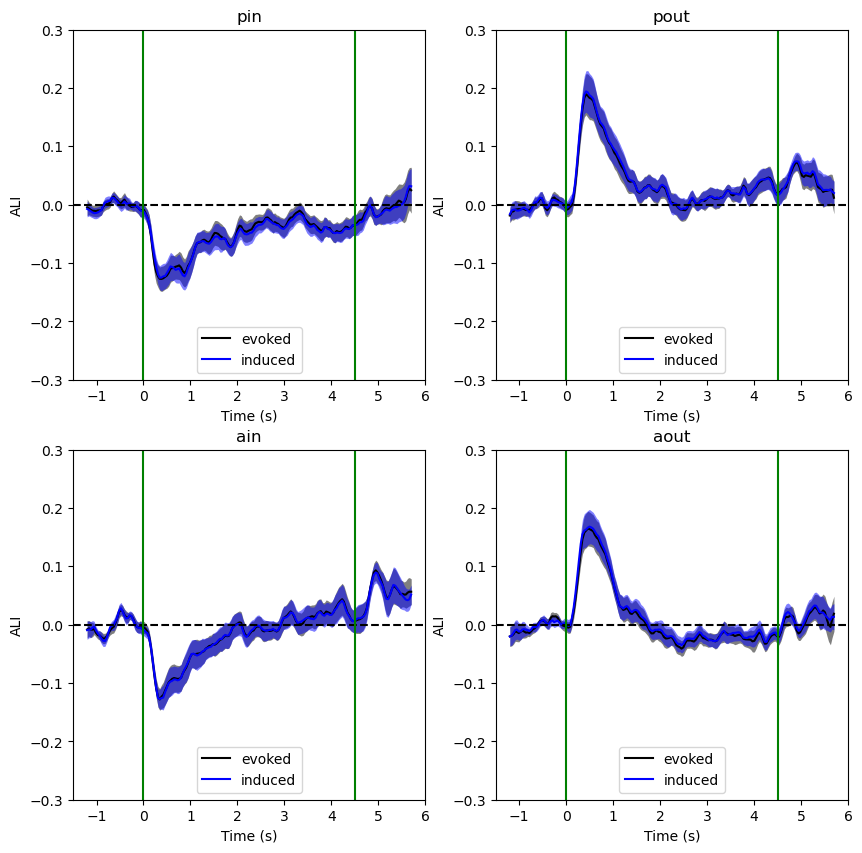

In [ ]:
## ALIs for evoked vs induced for No TMS
lim_val = 0.3
f, axs = plt.subplots(2, 2, figsize=(10, 10))
for jj, ax in zip([0,1,2,3], axs.ravel()):
    y1 = np.nanmean(ALI_evoked[0, jj, :, :], 0)
    y2 = np.nanmean(ALI_induced[0, jj, :, :], 0)
    y1_err = np.nanstd(ALI_evoked[0, jj, :, :], 0)/np.sqrt(len(sub_list))
    y2_err = np.nanstd(ALI_induced[0, jj, :, :], 0)/np.sqrt(len(sub_list))
    ax.plot(time_array, y1, 'k-', label='evoked')
    ax.plot(time_array, y2, 'b-', label='induced')
    ax.fill_between(time_array[:,0], y1-y1_err, y1+y1_err, alpha=0.5, linewidth=0, color='k')
    ax.fill_between(time_array[:,0], y2-y2_err, y2+y2_err, alpha=0.5, linewidth=0, color='b')
    ax.plot(time_array, np.zeros(len(time_array)), 'k--')
    ax.plot([0, 0], [-lim_val, lim_val], 'g-')
    ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
    ax.legend()
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(-lim_val, lim_val)
    ax.set_ylabel('ALI')
    ax.set_xlabel('Time (s)')
    ax.set_title(trial_types[jj])

In [ ]:
## ALIs for evoked for No TMS vs TMS
lim_val = 0.3
f, axs = plt.subplots(2, 2, figsize=(10, 10))
for jj, ax in zip([0,1,2,3], axs.ravel()):
    y1 = np.nanmean(ALI_evoked[0, jj, :, :], 0)
    y2 = np.nanmean(ALI_evoked[1, jj, :, :], 0)
    y1_err = np.nanstd(ALI_evoked[0, jj, :, :], 0)/np.sqrt(len(sub_list))
    y2_err = np.nanstd(ALI_evoked[1, jj, :, :], 0)/np.sqrt(len(sub_list))
    ax.plot(time_array, y1, 'b-', label='no tms')
    ax.plot(time_array, y2, 'r-', label='tms')
    ax.fill_between(time_array[:,0], y1-y1_err, y1+y1_err, alpha=0.5, linewidth=0, color='b')
    ax.fill_between(time_array[:,0], y2-y2_err, y2+y2_err, alpha=0.5, linewidth=0, color='r')
    ax.plot(time_array, np.zeros(len(time_array)), 'k--')
    ax.plot([0, 0], [-lim_val, lim_val], 'g-')
    ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
    ax.legend()
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(-lim_val, lim_val)
    ax.set_ylabel('ALI')
    ax.set_xlabel('Time (s)')
    ax.set_title(trial_types[jj])

In [ ]:
## ALIs for evoked for No TMS vs TMS
lim_val = 0.3
N = 8
cols = 2#int(np.ceil(np.sqrt(N)))
rows = int(np.ceil(N / cols))
f, axs = plt.subplots(rows, cols, figsize=(10, 20))
plt_counter = 0
for side in ['Left', 'Right']:
    for jj in [0, 1, 2, 3]:
        ax = axs[plt_counter // cols, plt_counter % cols]
        y1_holder = np.empty((0, ALI_evoked.shape[3]))
        y2_holder = np.empty((0, ALI_evoked.shape[3]))
        counter = 0
        for i, ss in enumerate(sub_list):
            if All_metadata[ss]['Hemisphere stimulated'] == side:
                slice_y1 = ALI_evoked[0, jj, i, :]
                slice_y2 = ALI_evoked[1, jj, i, :]
                y1_holder = np.concatenate((y1_holder, slice_y1[np.newaxis, :]), axis=0)
                y2_holder = np.concatenate((y2_holder, slice_y2[np.newaxis, :]), axis=0)
                counter += 1
        y1 = np.nanmean(y1_holder, 0)
        y2 = np.nanmean(y2_holder, 0)
        y1_err = np.nanstd(y1_holder, 0)/np.sqrt(counter)
        y2_err = np.nanstd(y2_holder, 0)/np.sqrt(counter)
        ax.plot(time_array, y1, 'b-', label='no tms')
        ax.plot(time_array, y2, 'r-', label='tms')
        ax.fill_between(time_array[:,0], y1-y1_err, y1+y1_err, alpha=0.5, linewidth=0, color='b')
        ax.fill_between(time_array[:,0], y2-y2_err, y2+y2_err, alpha=0.5, linewidth=0, color='r')
        ax.plot(time_array, np.zeros(len(time_array)), 'k--')
        ax.plot([0, 0], [-lim_val, lim_val], 'g-')
        ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
        ax.legend()
        ax.set_xlim(time_array[0], time_array[-1])
        ax.set_ylim(-lim_val, lim_val)
        ax.set_ylabel('ALI')
        ax.set_xlabel('Time (s)')
        ax.set_title(side + ': ' + trial_types[jj])
        plt_counter += 1

In [ ]:
## ALIs for evoked for No TMS vs TMS
lim_val = 0.5
N = 17*4
cols = 4#int(np.ceil(np.sqrt(N)))
rows = int(np.ceil(N / cols))
f, axs = plt.subplots(rows, cols, figsize=(20, 100))
plt_counter = 0
for i, ss in enumerate(sub_list):
    for jj in [0, 1, 2, 3]:
        ax = axs[plt_counter // cols, plt_counter % cols]
        y1 = ALI_induced[0, jj, i, :]
        y2 = ALI_induced[1, jj, i, :]

        ax.plot(time_array, y1, 'b-', label='no tms')
        ax.plot(time_array, y2, 'r-', label='tms')
        
        ax.plot(time_array, np.zeros(len(time_array)), 'k--')
        ax.plot([0, 0], [-lim_val, lim_val], 'g-')
        ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
        ax.legend()
        ax.set_xlim(time_array[0], time_array[-1])
        ax.set_ylim(-lim_val, lim_val)
        ax.set_ylabel('ALI')
        ax.set_xlabel('Time (s)')
        ax.set_title(str(ss) + ': ' + trial_types[jj])
        plt_counter += 1

## Decoding

In [11]:
idx_pin_ntms = master_df.loc[(master_df['istms']==0) & (master_df['t_type']==1)].index
mask = (time_array >= 0) & (time_array <= 4)
tidx = np.where(mask)[0]
X_temp = Xcommon_evoked[idx_pin_ntms, :]
X = X_temp[:, tidx]
this_df = master_df.iloc[idx_pin_ntms].reset_index(drop=True)
y = this_df['ierr']

n_trials, n_timepoints = X.shape
mse_per_timepoint = np.zeros(n_timepoints) 

loo = LeaveOneOut()

# Iterate over each time-point
for t in range(n_timepoints):
    y_preds = np.zeros(n_trials)
    y_true = y.copy()

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index, t].reshape(-1, 1), X[test_index, t].reshape(-1, 1)
        y_train, y_test = y[train_index], y[test_index]

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_preds[test_index] = y_pred

    mse_per_timepoint[t] = mean_squared_error(y_true, y_preds)

# n_permutations = 1000
# n_timepoints = X.shape[1]
# perm_mse = np.zeros((n_permutations, n_timepoints))

# for p in range(n_permutations):
#     y_perm = np.random.permutation(y)
#     for t in range(n_timepoints):
#         y_preds = np.zeros(n_trials)
#         y_true = y.copy()

#         for train_index, test_index in loo.split(X):
#             X_train, X_test = X[train_index, t].reshape(-1, 1), X[test_index, t].reshape(-1, 1)
#             y_train, y_test = y[train_index], y[test_index]

#             model = LinearRegression()
#             model.fit(X_train, y_train)

#             y_pred = model.predict(X_test)
#             y_preds[test_index] = y_pred

#         perm_mse[p, t] = mean_squared_error(y_true, y_preds)
# p_values = np.mean(perm_mse <= mse_per_timepoint, axis=0)

KeyboardInterrupt: 

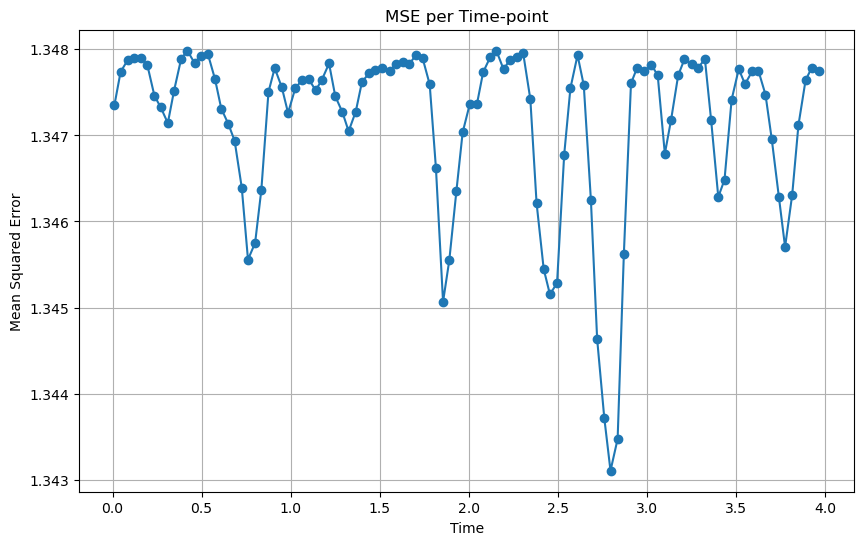

In [10]:
time_array_relevant = time_array[tidx]
plt.figure(figsize=(10, 6))
plt.plot(time_array_relevant, mse_per_timepoint, marker='o')
plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.title('MSE per Time-point')
plt.grid(True)
plt.show()

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC


idx_ntms = master_df.loc[(master_df['istms']==0)].index
mask = (time_array >= 0) & (time_array <= 4)
tidx = np.where(mask)[0]
X_temp = Xcommon_evoked[idx_ntms, :]
X = X_temp[:, tidx]
this_df = master_df.iloc[idx_ntms].reset_index(drop=True)
y = this_df['t_type']
#y = y.apply(lambda x: 1 if x in [1, 2] else 30)
n_trials, n_timepoints = X.shape
accuracy_per_timepoint = np.zeros(n_timepoints)

# loo = LeaveOneOut()
n_splits = 10
kf = KFold(n_splits=n_splits)

accuracy_per_timepoint = np.zeros(n_timepoints)

# Iterate over each time-point
for t in range(n_timepoints):
    y_preds = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index, t].reshape(-1, 1), X[test_index, t].reshape(-1, 1)
        y_train, y_test = y[train_index], y[test_index]

        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_preds.extend(model.predict(X_test))

    accuracy_per_timepoint[t] = accuracy_score(y, y_preds)

In [33]:
y.value_counts()

t_type
1    2969
4    2740
Name: count, dtype: int64

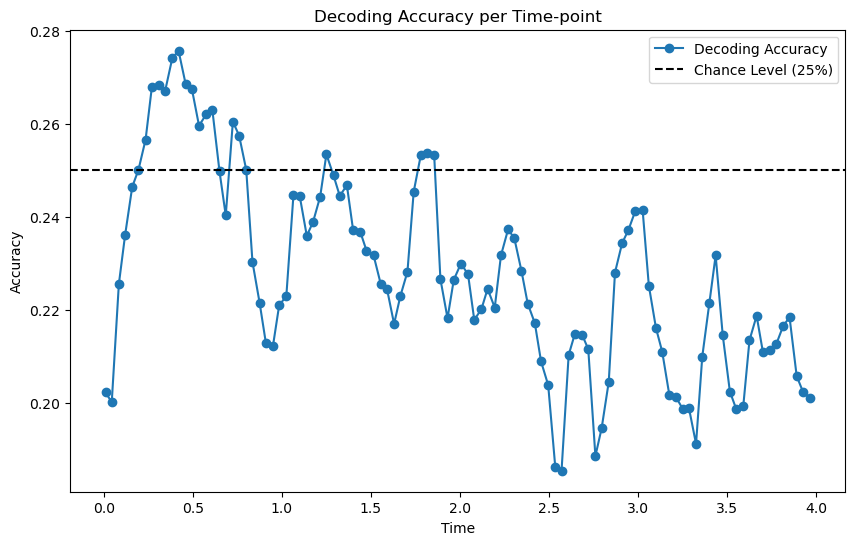

In [44]:
time_array_relevant = time_array[tidx]

plt.figure(figsize=(10, 6))
plt.plot(time_array_relevant, accuracy_per_timepoint, marker='o', label='Decoding Accuracy')
plt.axhline(y=0.25, color='k', linestyle='--', label='Chance Level (25%)')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('Decoding Accuracy per Time-point')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
accuracy_matrix = np.zeros((n_timepoints, n_timepoints))
loo = LeaveOneOut()

# Loop over each time-point for training
for train_time in range(n_timepoints):
    X_train_time = X[:, train_time].reshape(-1, 1)

    # Loop over each time-point for testing
    for test_time in range(n_timepoints):
        y_preds = np.zeros(n_trials)
        X_test_time = X[:, test_time].reshape(-1, 1)

        for train_index, test_index in loo.split(X_train_time):
            model = LogisticRegression()
            model.fit(X_train_time[train_index], y[train_index])
            y_pred = model.predict(X_test_time[test_index])
            y_preds[test_index] = y_pred

        accuracy_matrix[train_time, test_time] = accuracy_score(y, y_preds)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(accuracy_matrix, annot=True, cmap='viridis')
plt.xlabel('Test Time Point')
plt.ylabel('Train Time Point')
plt.title('Time-by-Time Generalization')
plt.show()

## Contralateral Delay Activity (CDA)

In [ ]:
# Load up ALI evoked and induced
with h5py.File(p['mCDA'], 'r') as f:
    mCDA = np.array(f['mCDA']).T

with h5py.File(os.path.join(p['EEGfiles'], 'sub01/day01/sub01_day01_erp.mat')) as f:
    tarray_erp = np.array(f['ERP']['pin']['time'])

In [ ]:
## CDAs for evoked for No TMS vs TMS
lim_val = 2
N = 8
cols = 4#int(np.ceil(np.sqrt(N)))
rows = int(np.ceil(N / cols))
f, axs = plt.subplots(rows, cols, figsize=(20, 10))
plt_counter = 0
for tms_cond in [0, 1]:
    for jj in [0, 1, 2, 3]:
        ax = axs[plt_counter // cols, plt_counter % cols]
        y1_holder = np.empty((0, len(tarray_erp)))
        for i, ss in enumerate(sub_list):
            if tms_cond == 0:
                dd_idx = int(All_metadata[ss]['No TMS day']-1)
                y1 = mCDA[i, dd_idx, jj, :]
            else:
                nodd_idx = int(All_metadata[ss]['No TMS day']-1)
                dd_idx = [dd for dd in [0,1,2] if dd!=nodd_idx]
                y1 = np.mean(mCDA[i, dd_idx, jj, :], axis = 0)
            y1_holder = np.concatenate((y1_holder, y1[np.newaxis, :]), axis=0)
        y1_holder = np.nanmean(y1_holder, axis = 0)
        win_size = 20 #samples
        tarray_plot = np.convolve(tarray_erp[:, 0], np.ones(win_size)/win_size, mode='valid')
        y1_plot = np.convolve(y1_holder, np.ones(win_size)/win_size, mode='valid')
        if tms_cond == 0:
            ax.plot(tarray_plot, y1_plot, 'b-', label=tms_cond)  
        else:
            ax.plot(tarray_plot, y1_plot, 'r-', label=tms_cond)      
        ax.plot(tarray_plot, np.zeros(len(tarray_plot)), 'k--')
        ax.plot([0, 0], [-lim_val, lim_val], 'g-')
        ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
        ax.legend()
        ax.set_xlim(tarray_plot[0], tarray_plot[-1])
        ax.set_ylim(-lim_val, lim_val)
        ax.set_ylabel('CDA')
        ax.set_xlabel('Time (s)')
        ax.set_title('CDA: ' + trial_types[jj])
        plt_counter += 1